# Contextual Bandits - Algorithm Implementation

In [1]:
import pandas as pd
from keras import Sequential, regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/jmacdonald/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
col_names = [
    'elevation',
    'aspect',
    'slope',
    'h_dist_hydro',
    'v_dist_hydro',
    'h_dist_road',
    'shade_9am',
    'shade_noon',
    'shade_3pm',
    'h_dist_fire',
]

col_names += ['wild_' + str(i) for i in range(4)]
col_names += ['soil_' + str(i) for i in range(40)]
col_names.append('cover_type')

In [3]:
df = pd.read_csv('./data/covtype.data.gz', names=col_names)
df = pd.get_dummies(df.sample(frac=1, replace=False), columns=['cover_type'])

X = df.values[:,:-7]
scalar = MinMaxScaler()
X = scalar.fit_transform(X)
Y = df.values[:,-7:]



/Users/jmacdonald/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
%%time

experts = [SGDClassifier(loss='log') for i in range(7)]
chosens = []
bests = []

for i in range(100000):
    context = X[i]
    try:
        selected = np.argmax([expert.predict_proba(context.reshape(1,-1))[1] for expert in experts])
        bests.append(selected)
    except:
        selected = np.random.choice(range(len(experts)))
    selected = np.random.choice([selected]+[np.random.choice(range(len(experts)))], p=[0.9,0.1])
    chosens.append(selected)
    expert = experts[selected]
    expert.partial_fit(context.reshape(1,-1), Y[i][[selected]], classes=[0,1])

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


CPU times: user 47 s, sys: 450 ms, total: 47.5 s
Wall time: 50.8 s


In [5]:
%%time 

results = pd.DataFrame([np.ravel([
    expert.predict_proba(X[i].reshape(1,-1))[0][1] for expert in experts
]) for i in range(100000,200000)])   

CPU times: user 49.7 s, sys: 666 ms, total: 50.3 s
Wall time: 55 s


In [117]:
results['Match'].mean()

0.66694

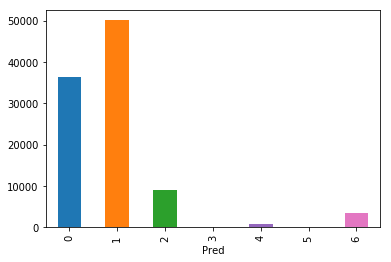

In [6]:
results['Pred'] = np.argmax(results.values, axis=1)
results['Class'] = np.argmax(Y[100000:200000],axis=1)
results['Match'] = (results['Pred']==results['Class'])
results.groupby('Pred').size().plot(kind='bar')

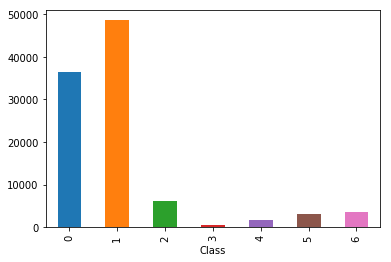

In [7]:
results.groupby('Class').size().plot(kind='bar')

In [8]:
def get_expert(input_shape, n_hidden, n_layers):

    expert = Sequential()
    for layer in range(n_layers):
        expert.add(Dense(n_hidden,
                        kernel_initializer='glorot_uniform',
                        activation='relu',
                        input_dim=input_shape,
                        kernel_regularizer=regularizers.l2(0.01)))
        expert.add(BatchNormalization())
        input_shape = n_hidden
    expert.add(Dense(1, activation='sigmoid', input_dim=n_hidden))
    return expert


In [115]:
%%time
experts = [get_expert(X.shape[1], 32, 1) for i in range(7)]
[ex.compile(optimizer='sgd',loss='binary_crossentropy') for ex in experts]


chosens = []
bests = []
corrects = []
cweights = {0:1,1:1,2:1,3:1,4:1,5:1,6:1}

for i in range(50001):
    context = X[i].reshape(1,-1)
    try:
        selected = np.argmax([expert.predict_proba(context.reshape(1,-1))[0] for expert in experts])
        bests.append(selected)
    except:
        selected = np.random.choice(range(len(experts)))
    selected = np.random.choice([selected]+[np.random.choice(range(len(experts)))], p=[0.9,0.1])
    chosens.append(selected)
    expert = experts[selected]
    expert.train_on_batch(context, Y[i][[selected]], class_weight=cweights)
    if Y[i][[selected]] == 1:
        cweights[selected] /= 1.001
        
    if i % 1000 == 0:
        print(i, 
              "accuracy:", 
              np.mean(np.argmax([expert.predict_proba(X[-1000:]) for expert in experts], axis=0
                       )[:,0] == np.argmax(Y[-1000:], axis=1))
             )

0 accuracy: 0.314
1000 accuracy: 0.136
2000 accuracy: 0.16
3000 accuracy: 0.168
4000 accuracy: 0.196
5000 accuracy: 0.219
6000 accuracy: 0.243
7000 accuracy: 0.275
8000 accuracy: 0.305
9000 accuracy: 0.33
10000 accuracy: 0.34
11000 accuracy: 0.348
12000 accuracy: 0.349
13000 accuracy: 0.348
14000 accuracy: 0.358
15000 accuracy: 0.365
16000 accuracy: 0.372
17000 accuracy: 0.373
18000 accuracy: 0.369
19000 accuracy: 0.374
20000 accuracy: 0.377
21000 accuracy: 0.378
22000 accuracy: 0.378
23000 accuracy: 0.378
24000 accuracy: 0.378
25000 accuracy: 0.377
26000 accuracy: 0.378
27000 accuracy: 0.38
28000 accuracy: 0.381
29000 accuracy: 0.38
30000 accuracy: 0.38
31000 accuracy: 0.382
32000 accuracy: 0.382
33000 accuracy: 0.38
34000 accuracy: 0.38
35000 accuracy: 0.38
36000 accuracy: 0.376
37000 accuracy: 0.38
38000 accuracy: 0.381
39000 accuracy: 0.381
40000 accuracy: 0.382
41000 accuracy: 0.38
42000 accuracy: 0.378
43000 accuracy: 0.379
44000 accuracy: 0.38
45000 accuracy: 0.379
46000 accurac

CPU times: user 9.53 s, sys: 462 ms, total: 9.99 s
Wall time: 8.87 s


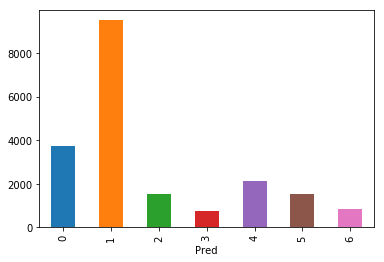

In [111]:
%%time 

keras_results = pd.DataFrame([np.ravel(expert.predict_proba(X[100000:120000])) for expert in experts]).T
keras_results['Pred'] = np.argmax(keras_results[list(range(7))].values, axis=1)
keras_results['Class'] = np.argmax(Y[100000:120000],axis=1)
keras_results['Match'] = (keras_results['Pred']==keras_results['Class'])
keras_results.groupby('Pred').size().plot(kind='bar')

In [113]:
keras_results['Match'].mean()

0.33845